# Import Semua Library yang Dibutuhkan
Pada tahap awal, kita mengimpor semua pustaka (library) yang diperlukan. Mengumpulkan semua impor di awal adalah praktik terbaik agar kode lebih rapi dan mudah dikelola.

In [48]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# Konfigurasi Path, Parameter, dan Nama Model
Di sel ini, kita mengatur semua variabel global yang akan digunakan di seluruh notebook, seperti path ke dataset, ukuran gambar, dan nama file untuk model yang akan kita simpan. Dengan cara ini, jika Anda ingin mengubah sesuatu (misalnya, nama model untuk eksperimen baru), Anda hanya perlu mengubahnya di satu tempat.

In [49]:
# Path ke dataset yang sudah di sorting
BASE_PATH = 'dataset coba'
train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

# Cek dan tampilkan struktur direktori
def print_directory_structure(path, indent=""):
    if os.path.exists(path):
        print(f"{indent}📂 {os.path.basename(path)}")
        try:
            for item in os.listdir(path):
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    print_directory_structure(item_path, indent + "  ")
                else:
                    print(f"{indent}  📄 {item}")
        except Exception as e:
            print(f"{indent}  ❌ Error reading directory: {str(e)}")
    else:
        print(f"{indent}❌ Path tidak ditemukan: {path}")

print("Struktur Dataset:")
print_directory_structure(BASE_PATH)

# Konfigurasi model
MODEL_NAME = 'coba_40.h5'
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100

# Deteksi kelas dari direktori training
if os.path.exists(train_dir):
    CLASSES = sorted(os.listdir(train_dir))
    print(f"\nKelas yang terdeteksi: {CLASSES}")
    print(f"Jumlah kelas: {len(CLASSES)}")
else:
    print("\nWarning: Training directory tidak ditemukan!")
    CLASSES = []

Struktur Dataset:
📂 dataset coba
  📂 test
    📂 healthy
      📄 sehat-106-_jpg.rf.9cca8a5f1427ecfffce38ef3e91eb666.jpg
      📄 sehat-106-_jpg.rf.a0082f9daffcb25da5e9e80e0bd2465e.jpg
      📄 sehat-106-_jpg.rf.e0fa4f09a93463de6ed6e5e5a281849f.jpg
      📄 sehat-114-_jpg.rf.71c63e7f2303a93cf6febb17ef641711.jpg
      📄 sehat-114-_jpg.rf.8653fe9154bf78664023e95d8ed67503.jpg
      📄 sehat-114-_jpg.rf.ec73217ff501fd804ee075675d04ed50.jpg
      📄 sehat-24-_jpg.rf.2bcab95abefed542c73f4338386103b9.jpg
      📄 sehat-24-_jpg.rf.ad9314d0c814accaade810a758ca8f1b.jpg
      📄 sehat-24-_jpg.rf.d08be9e0b508ee4f4e5c2e172c44574b.jpg
    📂 leaf curl
      📄 Curl Virus00007.JPG
      📄 Curl Virus00050.JPG
      📄 Curl Virus00068.JPG
      📄 Curl Virus00075.JPG
      📄 Curl Virus00169.JPG
      📄 download (11).jpg
      📄 images (11).jpg
      📄 images (14).jpg
      📄 images (33).jpg
      📄 images (34).jpg
      📄 images (37).jpg
    📂 leaf spot
      📄 leaf spot13 (1).jpg
      📄 leaf spot15 (1).jpg
      

# Persiapan Data (Data Augmentation & Generators)
Langkah ini sangat krusial. Kita akan menyiapkan "pipa" data menggunakan ImageDataGenerator. Untuk data training, kita akan menerapkan augmentasi data (memutar, zoom, flip) untuk membuat model lebih tangguh dan mencegah overfitting. Untuk data validasi dan test, kita hanya melakukan pra-pemrosesan tanpa augmentasi.

In [50]:
# Siapkan data augmentation untuk training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # Reduced from 40 to avoid extreme rotations
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validasi dan testing, hanya gunakan preprocessing
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

try:
    print("Memuat data training...")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=seed  
    )
    
    print("\nMemuat data validasi...")
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print("\nMemuat data testing...")
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print("\nJumlah sampel:")
    print(f"Training: {train_generator.samples}")
    print(f"Validasi: {val_generator.samples}")
    print(f"Testing: {test_generator.samples}")
    
except FileNotFoundError as e:
    print(f"Error: Directory tidak ditemukan. Pastikan struktur folder benar:\n{str(e)}")
except Exception as e:
    print(f"Error saat memuat data: {str(e)}")

Memuat data training...
Found 464 images belonging to 5 classes.



Memuat data validasi...
Found 84 images belonging to 5 classes.

Memuat data testing...
Found 50 images belonging to 5 classes.

Jumlah sampel:
Training: 464
Validasi: 84
Testing: 50


In [51]:
class_indices = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: np.float64(0.8923076923076924), 1: np.float64(0.7669421487603306), 2: np.float64(1.1746835443037975), 3: np.float64(1.16), 4: np.float64(1.16)}


# Membangun Arsitektur Model (Transfer Learning MobileNetV2)
Di sini kita membangun "otak" dari sistem kita. Kita menggunakan Transfer Learning dengan model MobileNetV2 yang sudah terlatih pada ImageNet. Kita "membekukan" lapisan dasar MobileNetV2 dan hanya melatih beberapa lapisan baru di atasnya.

In [52]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
 )
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Melatih Model
Sekarang saatnya melatih model kita. Kita menggunakan dua callbacks penting: EarlyStopping dan ModelCheckpoint untuk mencegah overfitting dan menyimpan model terbaik selama training.

In [53]:
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  verbose=1, 
                  restore_best_weights=True),
    ModelCheckpoint(MODEL_NAME, 
                    monitor='val_loss',  # <-- Menggunakan val_loss juga
                    save_best_only=True, 
                    mode='min')          # <-- Mode diubah ke 'min' karena loss lebih baik jika lebih kecil
]
checkpoint_cb = ModelCheckpoint(
    MODEL_NAME,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_cb, earlystop_cb],  # <- tambahkan ini
    verbose=1
 )

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.2478 - loss: 1.9516
Epoch 1: val_accuracy improved from -inf to 0.32143, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.2483 - loss: 1.9487 - val_accuracy: 0.3214 - val_loss: 1.7009
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4017 - loss: 1.5679
Epoch 2: val_accuracy improved from 0.32143 to 0.40476, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.4029 - loss: 1.5638 - val_accuracy: 0.4048 - val_loss: 1.4251
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4890 - loss: 1.3605
Epoch 3: val_accuracy improved from 0.40476 to 0.48810, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.4899 - loss: 1.3572 - val_accuracy: 0.4881 - val_loss: 1.2497
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.6360 - loss: 1.0845
Epoch 4: val_accuracy improved from 0.48810 to 0.59524, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 578ms/step - accuracy: 0.6362 - loss: 1.0830 - val_accuracy: 0.5952 - val_loss: 1.1108
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6314 - loss: 1.0424
Epoch 5: val_accuracy improved from 0.59524 to 0.64286, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.6321 - loss: 1.0393 - val_accuracy: 0.6429 - val_loss: 1.0157
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7355 - loss: 0.8361
Epoch 6: val_accuracy improved from 0.64286 to 0.67857, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7341 - loss: 0.8377 - val_accuracy: 0.6786 - val_loss: 0.9350
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7046 - loss: 0.8536
Epoch 7: val_accuracy improved from 0.67857 to 0.71429, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.7042 - loss: 0.8533 - val_accuracy: 0.7143 - val_loss: 0.8700
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7339 - loss: 0.7566
Epoch 8: val_accuracy improved from 0.71429 to 0.75000, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.7340 - loss: 0.7568 - val_accuracy: 0.7500 - val_loss: 0.8484
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7874 - loss: 0.6525
Epoch 9: val_accuracy did not improve from 0.75000
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7867 - loss: 0.6528 - val_accuracy: 0.7262 - val_loss: 0.8221
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7435 - loss: 0.7155
Epoch 10: val_accuracy did not improve from 0.75000
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7442 - loss: 0.7136 - val_accuracy: 0.7143 - val_loss: 0.8004
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7856 - loss: 0.6378
Epoch 11: val_accuracy did not improve from 0.75000
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.7862 - loss: 0.6370 - val_accuracy: 0.7381 - val_loss: 0.7567
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7891 - loss: 0.5980
Epoch 12: val_accuracy did

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.8637 - loss: 0.4258 - val_accuracy: 0.7619 - val_loss: 0.6352
Epoch 17/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8037 - loss: 0.5122
Epoch 17: val_accuracy improved from 0.76190 to 0.77381, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8044 - loss: 0.5121 - val_accuracy: 0.7738 - val_loss: 0.6472
Epoch 18/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8091 - loss: 0.5434
Epoch 18: val_accuracy did not improve from 0.77381
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8103 - loss: 0.5404 - val_accuracy: 0.7619 - val_loss: 0.6260
Epoch 19/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8924 - loss: 0.3439
Epoch 19: val_accuracy improved from 0.77381 to 0.78571, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.8914 - loss: 0.3460 - val_accuracy: 0.7857 - val_loss: 0.6404
Epoch 20/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8655 - loss: 0.4185
Epoch 20: val_accuracy did not improve from 0.78571
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.8650 - loss: 0.4191 - val_accuracy: 0.7857 - val_loss: 0.6172
Epoch 21/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8736 - loss: 0.4084
Epoch 21: val_accuracy improved from 0.78571 to 0.79762, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.8730 - loss: 0.4091 - val_accuracy: 0.7976 - val_loss: 0.6099
Epoch 22/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8743 - loss: 0.3934
Epoch 22: val_accuracy did not improve from 0.79762
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8738 - loss: 0.3946 - val_accuracy: 0.7857 - val_loss: 0.5897
Epoch 23/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8531 - loss: 0.3874
Epoch 23: val_accuracy did not improve from 0.79762
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8536 - loss: 0.3870 - val_accuracy: 0.7857 - val_loss: 0.5809
Epoch 24/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8654 - loss: 0.3679
Epoch 24: val_accuracy improved from 0.79762 to 0.80952, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8650 - loss: 0.3695 - val_accuracy: 0.8095 - val_loss: 0.5823
Epoch 25/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8623 - loss: 0.3793
Epoch 25: val_accuracy did not improve from 0.80952
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.8619 - loss: 0.3799 - val_accuracy: 0.8095 - val_loss: 0.5970
Epoch 26/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8510 - loss: 0.3996
Epoch 26: val_accuracy did not improve from 0.80952
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8513 - loss: 0.3992 - val_accuracy: 0.8095 - val_loss: 0.5783
Epoch 27/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9042 - loss: 0.3212
Epoch 27: val_accuracy did not improve from 0.80952
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9032 - loss: 0.3226 - val_accuracy: 0.7976 - val_loss: 0.5783
Epoch 28/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8260 - loss: 0.4800
Epoch 28: val_accuracy d

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.8586 - loss: 0.4207 - val_accuracy: 0.8214 - val_loss: 0.5588
Epoch 33/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8901 - loss: 0.3197
Epoch 33: val_accuracy did not improve from 0.82143
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.8900 - loss: 0.3203 - val_accuracy: 0.8095 - val_loss: 0.5616
Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8853 - loss: 0.3628
Epoch 34: val_accuracy did not improve from 0.82143
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.8849 - loss: 0.3631 - val_accuracy: 0.8214 - val_loss: 0.5568
Epoch 35/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9026 - loss: 0.2977
Epoch 35: val_accuracy did not improve from 0.82143
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.9020 - loss: 0.2993 - val_accuracy: 0.8214 - val_loss: 0.5582
Epoch 36/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9152 - loss: 0.2868
Epoch 36: val_accuracy d

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9113 - loss: 0.2582 - val_accuracy: 0.8333 - val_loss: 0.5719
Epoch 43/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9158 - loss: 0.2793
Epoch 43: val_accuracy did not improve from 0.83333
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.9154 - loss: 0.2799 - val_accuracy: 0.8095 - val_loss: 0.5488
Epoch 44/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8995 - loss: 0.3214
Epoch 44: val_accuracy did not improve from 0.83333
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.8992 - loss: 0.3210 - val_accuracy: 0.8095 - val_loss: 0.5454
Epoch 45/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8926 - loss: 0.2992
Epoch 45: val_accuracy did not improve from 0.83333
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8924 - loss: 0.3000 - val_accuracy: 0.8333 - val_loss: 0.5688
Epoch 46/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9179 - loss: 0.2446
Epoch 46: val_accuracy d

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.9059 - loss: 0.2734 - val_accuracy: 0.8452 - val_loss: 0.5613
Epoch 51/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9105 - loss: 0.2560
Epoch 51: val_accuracy did not improve from 0.84524
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.9108 - loss: 0.2560 - val_accuracy: 0.8095 - val_loss: 0.5358
Epoch 52/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9168 - loss: 0.2859
Epoch 52: val_accuracy did not improve from 0.84524
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9165 - loss: 0.2859 - val_accuracy: 0.8333 - val_loss: 0.5462
Epoch 53/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9066 - loss: 0.2526
Epoch 53: val_accuracy improved from 0.84524 to 0.85714, saving model to coba_40.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.9064 - loss: 0.2537 - val_accuracy: 0.8571 - val_loss: 0.5467
Epoch 54/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8908 - loss: 0.3033
Epoch 54: val_accuracy did not improve from 0.85714
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8910 - loss: 0.3025 - val_accuracy: 0.8452 - val_loss: 0.5250
Epoch 55/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8990 - loss: 0.3035
Epoch 55: val_accuracy did not improve from 0.85714
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8991 - loss: 0.3031 - val_accuracy: 0.8333 - val_loss: 0.5437
Epoch 56/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9091 - loss: 0.3029
Epoch 56: val_accuracy did not improve from 0.85714
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.9096 - loss: 0.3011 - val_accuracy: 0.8571 - val_loss: 0.5561
Epoch 57/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9020 - loss: 0.2537
Epoch 57: val_accuracy d

# Visualisasi Hasil Training (Grafik Akurasi & Loss)
Setelah training selesai, kita harus memvisualisasikan hasilnya. Grafik ini membantu kita memahami bagaimana performa model selama proses training dan validasi.

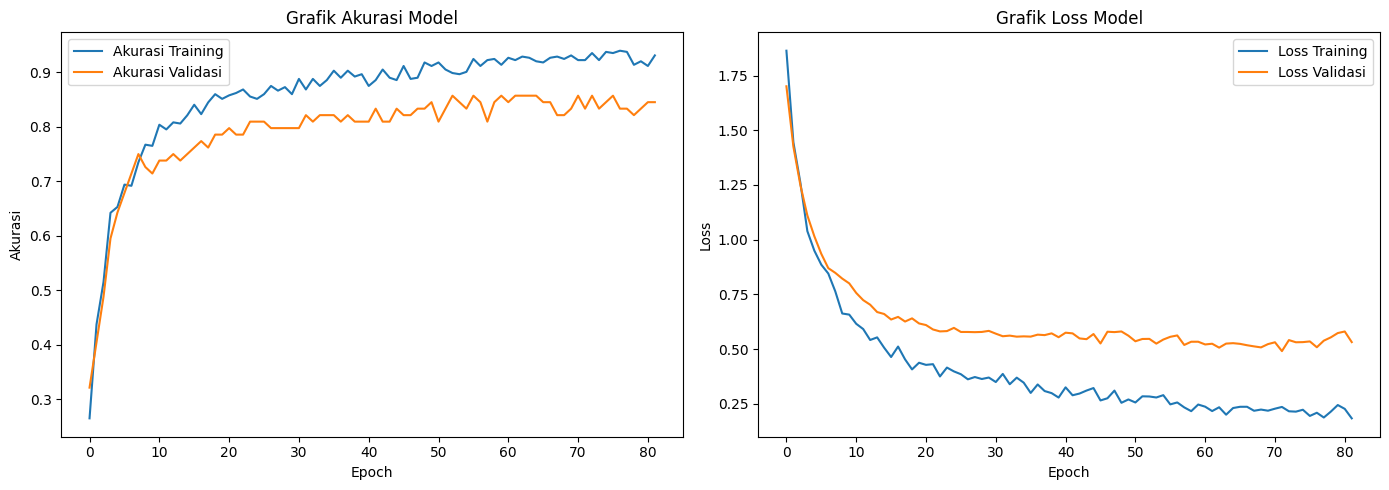

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Akurasi Training')
plt.plot(val_acc, label='Akurasi Validasi')
plt.title('Grafik Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss Training')
plt.plot(val_loss, label='Loss Validasi')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluasi Final pada Data Test
Kita memuat model terbaik yang disimpan oleh ModelCheckpoint dan mengujinya pada test set—data yang sama sekali belum pernah dilihat model selama training.

In [55]:
best_model = load_model(MODEL_NAME)
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)
print(f"Akurasi pada data test: {test_acc:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9691 - loss: 0.1078
Akurasi pada data test: 98.00%


# Analisis Mendalam - Confusion Matrix & Classification Report
Akurasi saja tidak cukup. Confusion Matrix dan Classification Report menunjukkan secara detail di mana model kita membuat kesalahan dan seberapa baik model mengenali tiap kelas.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step

Laporan Klasifikasi untuk Data Test:

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         9
   leaf curl       1.00      0.91      0.95        11
   leaf spot       1.00      1.00      1.00        10
    whitefly       1.00      1.00      1.00        10
   yellowish       0.91      1.00      0.95        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



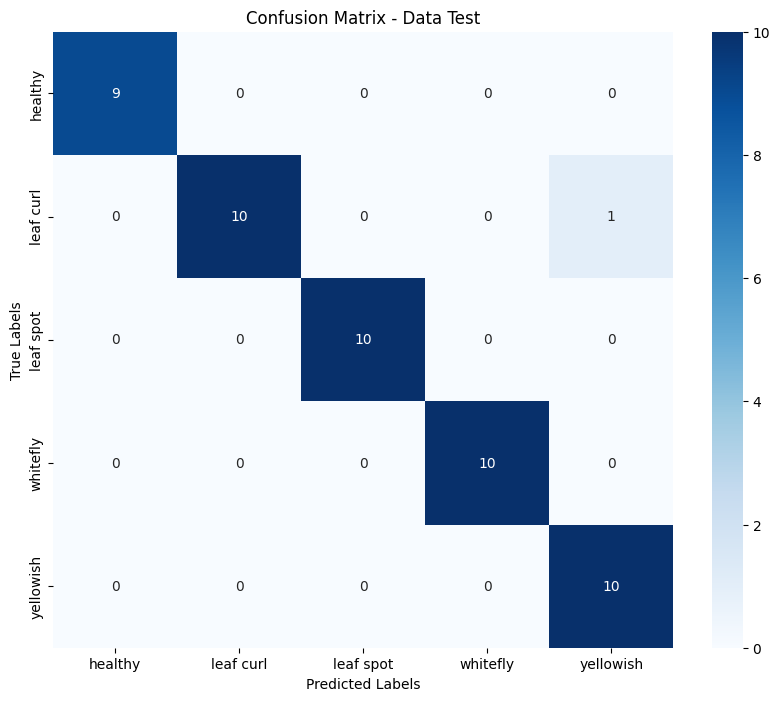


Laporan Klasifikasi untuk Data Test:

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         9
   leaf curl       1.00      0.91      0.95        11
   leaf spot       1.00      1.00      1.00        10
    whitefly       1.00      1.00      1.00        10
   yellowish       0.91      1.00      0.95        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



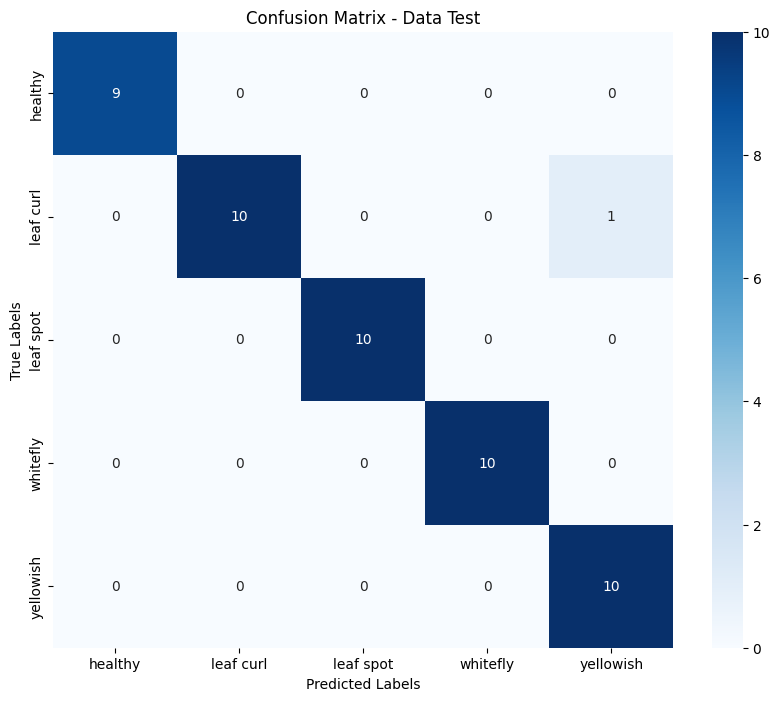

In [56]:
import seaborn as sns

steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
Y_pred = best_model.predict(test_generator, steps=steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("\nLaporan Klasifikasi untuk Data Test:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Data Test')
plt.show()
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("\nLaporan Klasifikasi untuk Data Test:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Data Test')
plt.show()

# Uji Coba Prediksi pada Gambar Tunggal
Terakhir, kita buat fungsi untuk menguji model seperti pada aplikasi nyata: memasukkan satu gambar dan melihat apa hasil prediksinya.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


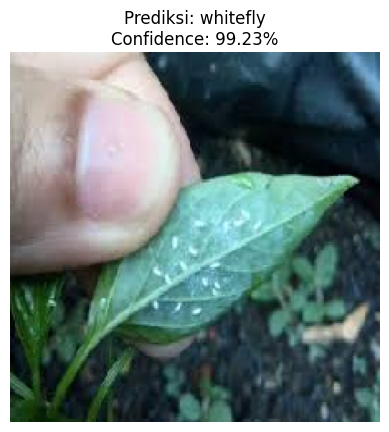

('whitefly', np.float32(0.9922942))

In [57]:
def predict_single_image(img_path, model, class_names, threshold=0.5):
    try:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        pred = model.predict(img_array)
        class_idx = np.argmax(pred[0])
        confidence = pred[0][class_idx]
        plt.imshow(img)
        if confidence < threshold:
            predicted_class = "Tidak Dikenali (Confidence Rendah)"
            title_text = f'Prediksi: {predicted_class}\nConfidence: {confidence:.2%}'
        else:
            predicted_class = class_names[class_idx]
            title_text = f'Prediksi: {predicted_class}\nConfidence: {confidence:.2%}'
        plt.title(title_text)
        plt.axis('off')
        plt.show()
        return predicted_class, confidence
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di path '{img_path}'")
        return None, None
    except Exception as e:
        print(f"Terjadi error saat memproses gambar: {e}")
        return None, None

# Contoh penggunaan:
test_image_path = 'image.png'  # Ganti dengan path gambar yang ingin diuji
predict_single_image(test_image_path, best_model, CLASSES, threshold=0.5)

# Testing Model dengan Gambar Baru

Mari kita coba model untuk memprediksi beberapa gambar yang berbeda. Pastikan path gambar sudah sesuai dengan lokasi gambar yang ingin diuji.


Memprediksi gambar: dataset coba/test/leaf spot/leaf spot13 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


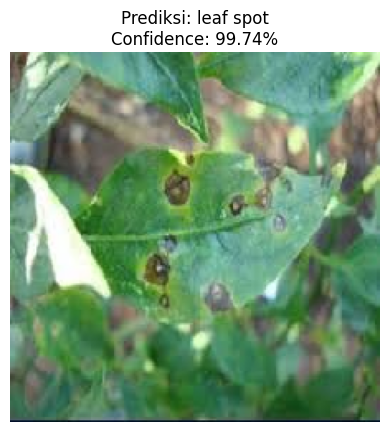

Hasil Prediksi: leaf spot dengan confidence 99.74%


Memprediksi gambar: dataset coba/test/healthy/sehat-24-_jpg.rf.ad9314d0c814accaade810a758ca8f1b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


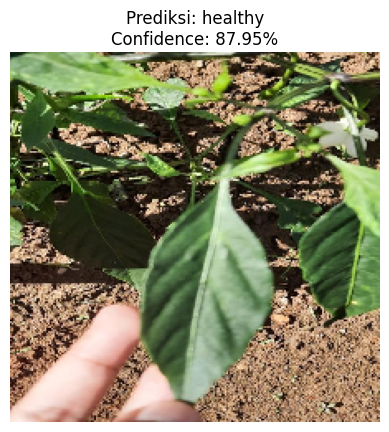

Hasil Prediksi: healthy dengan confidence 87.95%


Memprediksi gambar: dataset coba/test/healthy/sehat-24-_jpg.rf.d08be9e0b508ee4f4e5c2e172c44574b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


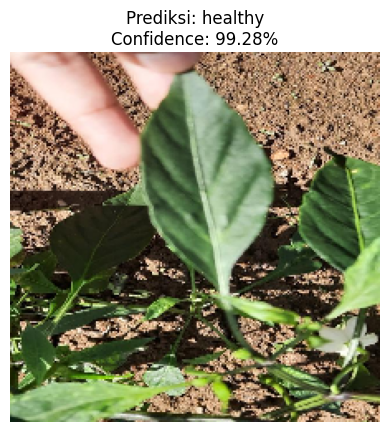

Hasil Prediksi: healthy dengan confidence 99.28%


Memprediksi gambar: dataset coba/test/healthy/sehat-114-_jpg.rf.ec73217ff501fd804ee075675d04ed50.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


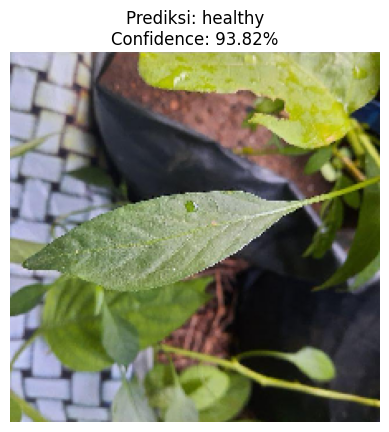

Hasil Prediksi: healthy dengan confidence 93.82%


Memprediksi gambar: image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


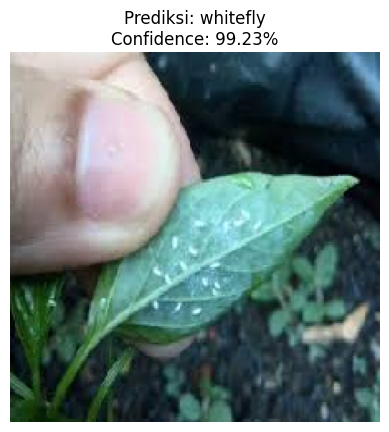

Hasil Prediksi: whitefly dengan confidence 99.23%


Memprediksi gambar: leaf spot.png
Error: File gambar tidak ditemukan di path 'leaf spot.png'


In [58]:
# Load model yang sudah dilatih
model_path = 'coba_coba_mobilenet_v2.h5'
loaded_model = load_model(model_path)

# List gambar yang akan diuji
test_images = [
    'dataset coba/test/leaf spot/leaf spot13 (1).jpg',  
    'dataset coba/test/healthy/sehat-24-_jpg.rf.ad9314d0c814accaade810a758ca8f1b.jpg',
    'dataset coba/test/healthy/sehat-24-_jpg.rf.d08be9e0b508ee4f4e5c2e172c44574b.jpg',
    'dataset coba/test/healthy/sehat-114-_jpg.rf.ec73217ff501fd804ee075675d04ed50.jpg',
    'image.png',
    'leaf spot.png'
]

# Lakukan prediksi untuk setiap gambar
for img_path in test_images:
    print(f"\nMemprediksi gambar: {img_path}")
    predicted_class, confidence = predict_single_image(img_path, loaded_model, CLASSES, threshold=0.1)
    if predicted_class and confidence:
        print(f"Hasil Prediksi: {predicted_class} dengan confidence {confidence:.2%}\n")

# Testing Model Secara Independen

Bagian ini berisi kode lengkap untuk testing model yang sudah dilatih, termasuk semua import dan konfigurasi yang diperlukan.